In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertModel, DistilBertTokenizer
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# -----------------------------
# Custom Dataset for Multi-Modal Input
# -----------------------------
class MultiModalDataset(Dataset):
    def __init__(self, root, image_transform, tokenizer, max_len):
        """
        Uses the folder structure (ImageFolder format) for images.
        Also extracts text from the image file names.
        """
        # Use ImageFolder to get image samples and labels.
        self.image_dataset = datasets.ImageFolder(root, transform=image_transform)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.image_dataset)

    def __getitem__(self, idx):
        # Get image and label from the ImageFolder dataset.
        image, label = self.image_dataset[idx]
        # Extract the file path from the dataset's samples.
        filepath, _ = self.image_dataset.samples[idx]
        # Extract text from the file name (remove extension, replace underscores, and remove digits)
        filename = os.path.basename(filepath)
        text = os.path.splitext(filename)[0]
        text = text.replace('_', ' ')
        text = re.sub(r'\d+', '', text)

        # Tokenize the text using DistilBERT tokenizer.
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        # Squeeze to remove extra dimensions.
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return {
            'image': image,
            'text': text,  # original text (optional)
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }

# -----------------------------
# Multi-Modal Classifier Model
# -----------------------------
class MultiModalClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MultiModalClassifier, self).__init__()
        # ----- Image Backbone: ResNet18 -----
        self.image_model = models.resnet18(weights="IMAGENET1K_V1")

        # Optionally, freeze the ResNet18 layers if desired:
        # for param in self.image_model.parameters():
        #     param.requires_grad = False

        # Replace the final fully connected layer with an identity to extract features
        num_features_img = self.image_model.fc.in_features
        self.image_model.fc = nn.Identity()

        # ----- Text Backbone: DistilBERT -----
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        num_features_text = self.text_model.config.hidden_size  # typically 768

        # ----- Fusion and Classification Head -----
        combined_features = num_features_img + num_features_text
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(combined_features, num_classes)

    def forward(self, image, input_ids, attention_mask):
        # Extract image features from ResNet18
        image_features = self.image_model(image)  # shape: (batch, num_features_img)

        # Extract text features: use the [CLS] token representation (first token)
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0]  # shape: (batch, hidden_size)

        # Concatenate image and text features
        combined = torch.cat((image_features, text_features), dim=1)
        combined = self.dropout(combined)
        logits = self.classifier(combined)
        return logits

# -----------------------------
# Training and Evaluation Functions
# -----------------------------
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch in dataloader:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, dim=1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, dim=1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def test_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss, np.array(all_preds), np.array(all_labels)

# -----------------------------
# Main Training Loop
# -----------------------------
if __name__ == "__main__":
    # Define paths to your dataset folders (adjust these as needed)
    TRAIN_PATH = r"/work/TALC/enel645_2025w/garbage_data/CVPR_2024_dataset_Train"
    VAL_PATH = r"/work/TALC/enel645_2025w/garbage_data/CVPR_2024_dataset_Val"
    TEST_PATH = r"/work/TALC/enel645_2025w/garbage_data/CVPR_2024_dataset_Test"

    # Image transformations
    image_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    # Tokenizer and maximum text length
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    max_len = 24

    # Create datasets
    train_dataset = MultiModalDataset(TRAIN_PATH, image_transform, tokenizer, max_len)
    val_dataset = MultiModalDataset(VAL_PATH, image_transform, tokenizer, max_len)
    test_dataset = MultiModalDataset(TEST_PATH, image_transform, tokenizer, max_len)

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=1)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=1)

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Instantiate the model
    num_classes = 4  # blue bin, black bin, green bin, other
    model = MultiModalClassifier(num_classes=num_classes)
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=2e-5)

    # Training parameters
    EPOCHS = 10
    best_val_loss = float('inf')


    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = eval_epoch(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}/{EPOCHS}:", flush=True)
        print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}", flush=True)
        print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}", flush=True)

        # Save best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_multimodal_model.pth')


    # Load the best model and evaluate on the test set
    model.load_state_dict(torch.load('best_multimodal_model.pth'))
    test_loss, test_preds, test_labels = test_epoch(model, test_loader, criterion, device)
    test_accuracy = (test_preds == test_labels).mean() * 100
    print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%", flush=True)

    # Plot the confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig('confusion_matrix.png')
    plt.show()


# Output generated by the code:

```
Epoch 1/10:
  Train Loss: 0.4184, Train Accuracy: 0.8456
  Val Loss: 0.3066, Val Accuracy: 0.8883
Epoch 2/10:
  Train Loss: 0.2450, Train Accuracy: 0.9114
  Val Loss: 0.2975, Val Accuracy: 0.8956
Epoch 3/10:
  Train Loss: 0.1726, Train Accuracy: 0.9393
  Val Loss: 0.3166, Val Accuracy: 0.8928
Epoch 4/10:
  Train Loss: 0.1259, Train Accuracy: 0.9543
  Val Loss: 0.3618, Val Accuracy: 0.8922
Epoch 5/10:
  Train Loss: 0.0941, Train Accuracy: 0.9678
  Val Loss: 0.3678, Val Accuracy: 0.8972
Epoch 6/10:
  Train Loss: 0.0660, Train Accuracy: 0.9780
  Val Loss: 0.4007, Val Accuracy: 0.8994
Epoch 7/10:
  Train Loss: 0.0598, Train Accuracy: 0.9800
  Val Loss: 0.4073, Val Accuracy: 0.8961
Epoch 8/10:
  Train Loss: 0.0445, Train Accuracy: 0.9862
  Val Loss: 0.4651, Val Accuracy: 0.8967
Epoch 9/10:
  Train Loss: 0.0401, Train Accuracy: 0.9862
  Val Loss: 0.4990, Val Accuracy: 0.9006
Epoch 10/10:
  Train Loss: 0.0375, Train Accuracy: 0.9878
  Val Loss: 0.4722, Val Accuracy: 0.8961

Test Loss: 0.3942, Test Accuracy: 86.3054%
```

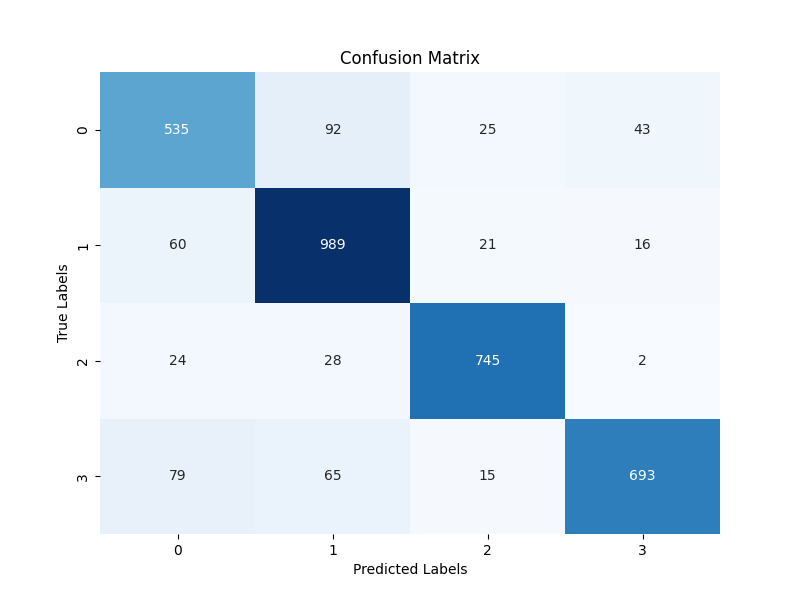
